# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [ ]:
#!pip install torch --upgrade
#!pip uninstall torch
!pip install torch==2.2.2
!pip install torchvision==0.17.2

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(8,8)) #=(15,15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

#data = torchvision.datasets.StanfordCars(root=".", download=True)
#show_images(data)

Matplotlib is building the font cache; this may take a moment.


In [ ]:
trainset = torchvision.datasets.CIFAR10(root=root, download=True)
 #= CIFAR10(root=root, train=True, download=True, transform=transform) #'./data'
# Create a new dataset containing only the cars
train_cars = []
test_cars = []

for i, (image, label) in enumerate(trainset):
    if label == 9:  # Label for cars
        train_cars.append((image, label))

print(len(trainset))
print(len(train_cars))

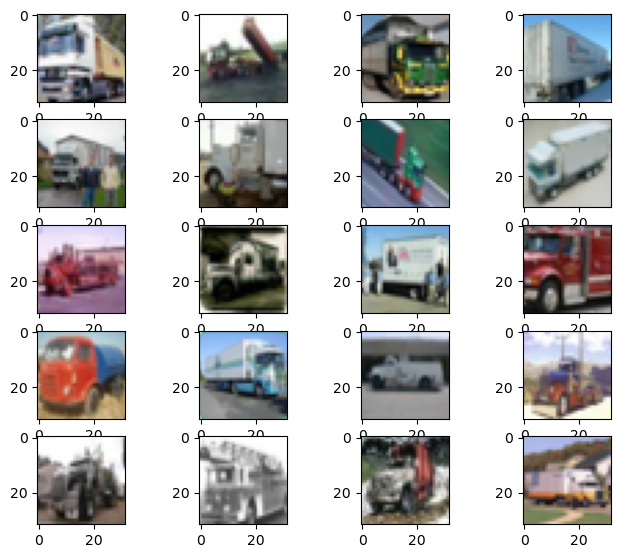

In [65]:
root='./data'
# Load the CIFAR-10 dataset
data = train_cars#torchvision.datasets.CIFAR10(root=root, download=True)
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [69]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32 # 32 for CIFAR; 64 for Cars
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.CIFAR10(root=root, download=True,
                                         transform=data_transform) #torchvision.datasets.StanfordCars

    #test = torchvision.datasets.CIFAR10(root=".", download=True,
    #                                   transform=data_transform, split='test')
    test = torchvision.datasets.CIFAR10(root=root, train=False,
                                       download=True, transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))



AttributeError: module 'torch.library' has no attribute 'register_fake'

In [98]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
return
data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
data_transform = transforms.Compose(data_transforms)

trainset = torchvision.datasets.CIFAR10(root=root, download=True,
                                         transform=data_transform) #torchvision.datasets.StanfordCars #'./data'
# Create a new dataset containing only the cars
train_cars = []
for i, (image, label) in enumerate(trainset):
    if label == 9:  # Label for cars
        train_cars.append((image, label))

print(len(trainset))
print(len(train_cars))
dataloader = DataLoader(train_cars, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


SyntaxError: 'return' outside function (3425825207.py, line 3)

/var/folders/k8/w0crzgr135n64vh05r_pvccr0000gn/T/ipykernel_14784/1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


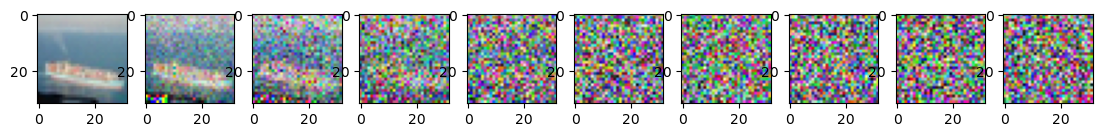

In [104]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [78]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
#model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [80]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [82]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

mps
Epoch 0 | step 000 Loss: 0.17661617696285248 


/var/folders/k8/w0crzgr135n64vh05r_pvccr0000gn/T/ipykernel_14784/3576216167.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


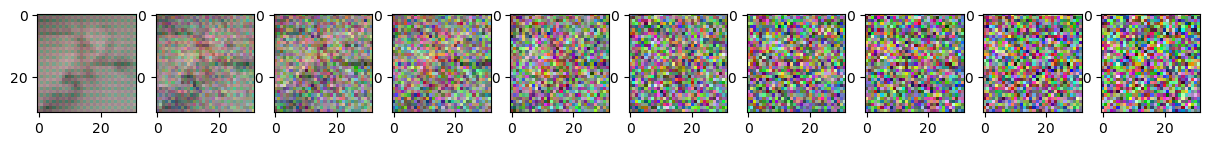

Epoch 0 | step 020 Current time: 2024-10-11 15:57:13.167030
Epoch 0 | step 040 Current time: 2024-10-11 15:57:31.791933
Epoch 0 | step 060 Current time: 2024-10-11 15:57:50.424626
Epoch 0 | step 080 Current time: 2024-10-11 15:58:09.070338
Epoch 0 | step 100 Current time: 2024-10-11 15:58:27.698542
Epoch 0 | step 120 Current time: 2024-10-11 15:58:46.378618
Epoch 0 | step 140 Current time: 2024-10-11 15:59:05.145615
Epoch 0 | step 160 Current time: 2024-10-11 15:59:23.934249
Epoch 0 | step 180 Current time: 2024-10-11 15:59:42.691537
Epoch 0 | step 200 Current time: 2024-10-11 16:00:01.445661
Epoch 0 | step 220 Current time: 2024-10-11 16:00:20.224047
Epoch 0 | step 240 Current time: 2024-10-11 16:00:38.987013
Epoch 0 | step 260 Current time: 2024-10-11 16:00:57.760996
Epoch 0 | step 280 Current time: 2024-10-11 16:01:16.513266
Epoch 0 | step 300 Current time: 2024-10-11 16:01:35.274642
Epoch 0 | step 320 Current time: 2024-10-11 16:01:54.022320
Epoch 0 | step 340 Current time: 2024-10

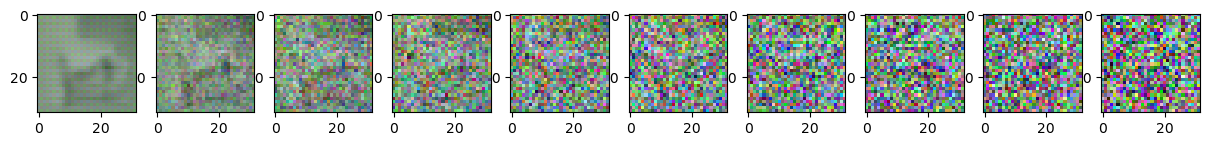

Epoch 5 | step 020 Current time: 2024-10-11 16:33:53.102245
Epoch 5 | step 040 Current time: 2024-10-11 16:34:11.756230
Epoch 5 | step 060 Current time: 2024-10-11 16:34:30.477180
Epoch 5 | step 080 Current time: 2024-10-11 16:34:49.117194
Epoch 5 | step 100 Current time: 2024-10-11 16:35:07.766278
Epoch 5 | step 120 Current time: 2024-10-11 16:35:26.451256
Epoch 5 | step 140 Current time: 2024-10-11 16:35:45.155047
Epoch 5 | step 160 Current time: 2024-10-11 16:36:03.836143
Epoch 5 | step 180 Current time: 2024-10-11 16:36:22.667784
Epoch 5 | step 200 Current time: 2024-10-11 16:36:41.449258
Epoch 5 | step 220 Current time: 2024-10-11 16:37:00.235785
Epoch 5 | step 240 Current time: 2024-10-11 16:37:19.041399
Epoch 5 | step 260 Current time: 2024-10-11 16:37:37.867179
Epoch 5 | step 280 Current time: 2024-10-11 16:37:56.648488
Epoch 5 | step 300 Current time: 2024-10-11 16:38:15.485484
Epoch 5 | step 320 Current time: 2024-10-11 16:38:34.307308
Epoch 5 | step 340 Current time: 2024-10

In [111]:
from torch.optim import Adam
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(device)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10#00 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
      elif step%20 == 0:
        print(f"Epoch {epoch} | step {step:03d} Current time: {datetime.datetime.now()}")


/var/folders/k8/w0crzgr135n64vh05r_pvccr0000gn/T/ipykernel_14784/3576216167.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


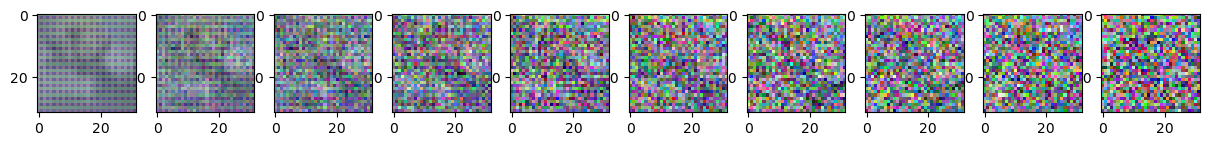

In [114]:
sample_plot_image()

In [57]:
import sys

print(sys.executable)

# prompt: python code to print current time
current_time = datetime.datetime.now()
print("Current time:", datetime.datetime.now())

print(torch.backends.mps.is_available())

/Users/afa/anaconda3/bin/python
Current time: 2024-10-11 11:21:38.183249
True


In [ ]:
# prompt: get torch vision dataset
---
import torchvision

# Example: Downloading and using the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# You can access images and labels from the dataset
image, label = train_dataset[0]

# Explore other datasets available in torchvision.datasets
# such as MNIST, FashionMNIST, COCO, etc.
